# Regression models


<a target="_blank" href="https://colab.research.google.com/github/carsten-j/learningbayesianstatistics/blob/main/Rethinking/chapter4.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


https://github.com/ecotner/statistical-rethinking/blob/master/notebooks/04_geocentric_models.ipynb
https://www.probabilistic-numerics.org/teaching/2022_Numerics_of_Machine_Learning/

In [174]:
# %pip install preliz

In [175]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import scipy.stats as st
import seaborn as sns
from numpy.linalg import inv
from scipy.stats import norm, uniform

In [176]:
az.style.use("arviz-white")

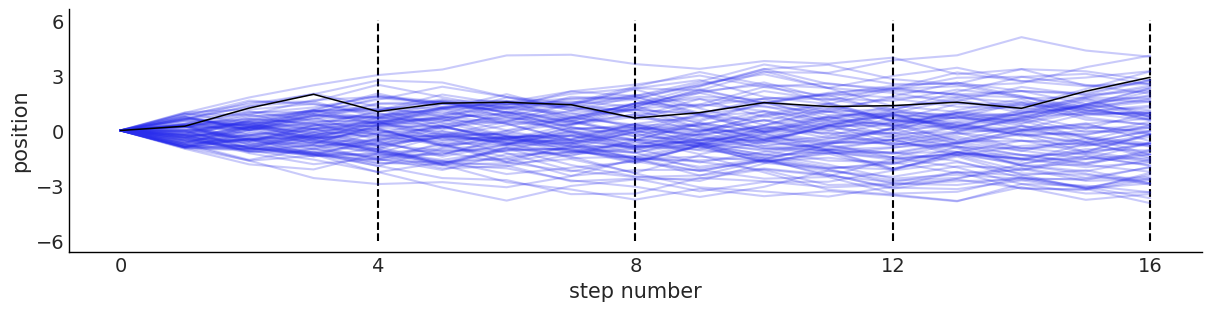

In [225]:
x = st.uniform(-1, 2).rvs(size=(100, 16))
fig, ax = plt.subplots(figsize=(12, 3))
ax.set(xlabel="step number", ylabel="position", xticks=[0, 4, 8, 12, 16], yticks=[-6, -3, 0, 3, 6])

for i, step in enumerate((4, 8, 12, 16)):
    ax.vlines(x=step, ymin=-6, ymax=6, linestyles="dashed", color="black")
for steps in np.hstack([np.zeros((99, 1)), x[:99]]):
    ax.plot(np.cumsum(steps), color="C0", alpha=0.25)
ax.plot(np.cumsum(np.hstack([np.zeros((1, 1)), x[99:]])), color="black", linewidth=1.1)

In [178]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv",
    sep=";",
)

In [179]:
df.head(5)

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [180]:
def precis(df):
    return df.describe(percentiles=[0.055, 0.945])

In [181]:
precis(df)

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
5.5%,81.108550,9.360721,1.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
94.5%,165.735000,54.502894,66.135000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [182]:
df = df[df["age"] >= 18]

In [183]:
precis(df)

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
5.5%,142.875000,35.137504,20.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
94.5%,167.005000,55.765876,70.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [184]:
def prior_samles(mean, std, uniform_upper, size):
    sample_mu = norm.rvs(loc=mean, scale=std, size=size)
    sample_sigma = uniform.rvs(loc=0, scale=uniform_upper, size=size)
    prior = norm.rvs(loc=sample_mu, scale=sample_sigma)
    return prior

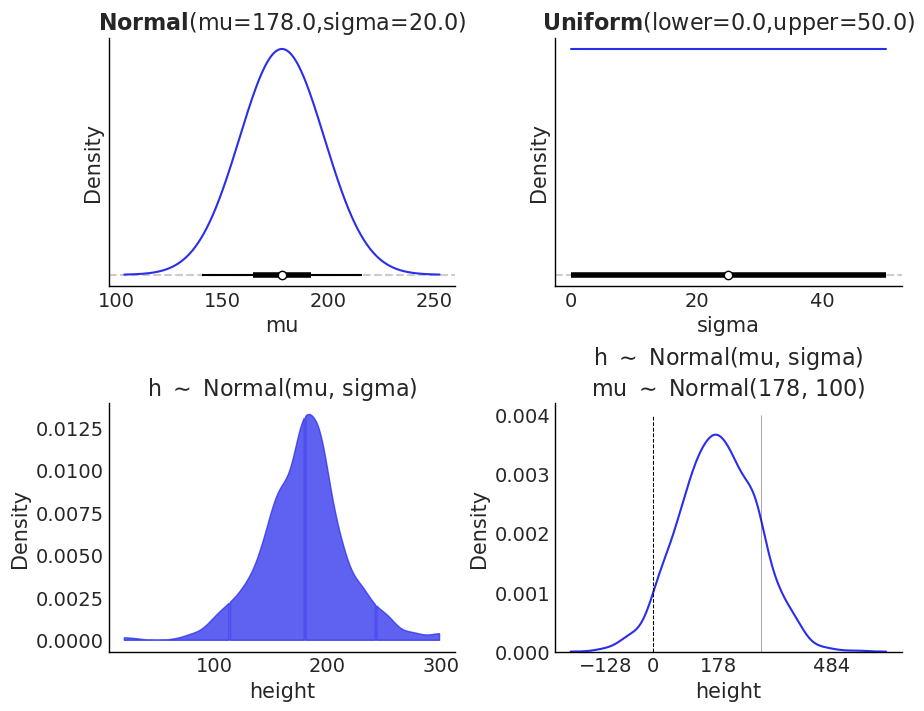

In [185]:
from turtle import left
from matplotlib.pyplot import xlabel, ylabel


prior_20 = prior_samles(178.0, 20.0, 50.0, 1000)
prior_100 = prior_samles(178.0, 100.0, 50.0, 1000)

fig, ax = plt.subplots(2, 2, figsize=(9, 7))
# fig.tight_layout(h_pad=2.0)
ax[0, 0].set(ylabel="Density", xlabel="mu")
pz.Normal(mu=178, sigma=20).plot_pdf(pointinterval=True, legend="title", ax=ax[0, 0])
ax[0, 1].set(ylabel="Density", xlabel="sigma")
pz.Uniform(lower=0, upper=50).plot_pdf(pointinterval=True, legend="title", ax=ax[0, 1])
ax[1, 0].set(title=r"h $\sim$ Normal(mu, sigma)", ylabel="Density", xlabel="height")
az.plot_kde(prior_20, ax=ax[1, 0], quantiles=[0.045, 0.5, 0.955])
ax[1, 1].set(
    title=r"h $\sim$ Normal(mu, sigma)" + "\n" + r"mu $\sim$ Normal(178, 100)",
    ylabel="Density",
    xlabel="height",
)
sns.kdeplot(prior_100, ax=ax[1, 1])
ax[1, 1].set_xticks([-128, 0, 178, 484])
ax[1, 1].vlines(
    x=0, ymin=0, ymax=0.004, linestyle="dashed", color="black", linewidth=0.75
)
ax[1, 1].vlines(
    x=292,
    ymin=0,
    ymax=0.004,
    linestyle="solid",
    color="black",
    alpha=0.5,
    linewidth=0.5,
)
# az.plot_kde(prior_100, ax=ax[1, 1])

In [186]:
x = np.linspace(0, 1, 100)

# def a_preliz_model(a_mu, a_sigma, c_sigma=1):
#     a = pz.Normal(a_mu, a_sigma).rvs()
#     c = pz.Gamma(mu=2, sigma=c_sigma).rvs()
#     b = pz.Normal(a*x, c).rvs()
#     return b


def a_preliz_model(a_mu, a_sigma):
    a = pz.Normal(mu=a_mu, sigma=a_sigma).rvs()
    b = pz.Uniform(lower=0, upper=50).rvs()
    y = pz.Normal(a, b).rvs(50)
    return y

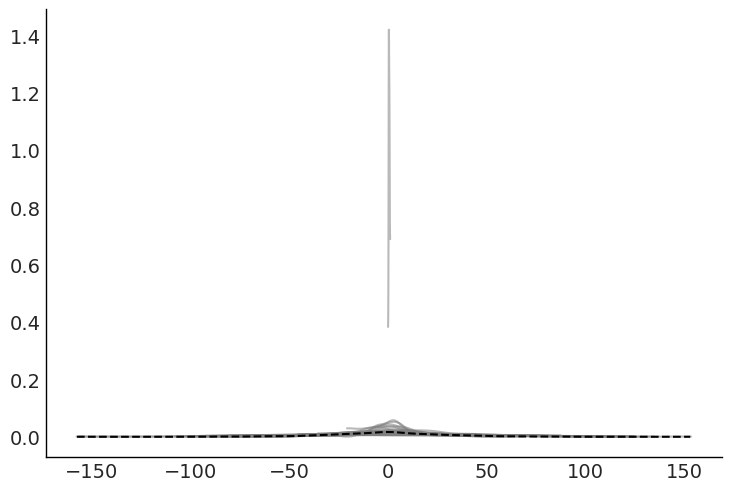

In [187]:
# plot_func set to custom_hist
pz.predictive_explorer(a_preliz_model, kind_plot="kde")

In [188]:
np.random.seed(1237)


def a_preliz_model():
    a = pz.Normal(mu=178, sigma=20).rvs()
    b = pz.Uniform(lower=0, upper=50).rvs()
    y = pz.Normal(a, b).rvs(100)
    return a, b, y

"This is an experimental method under development, use with caution.


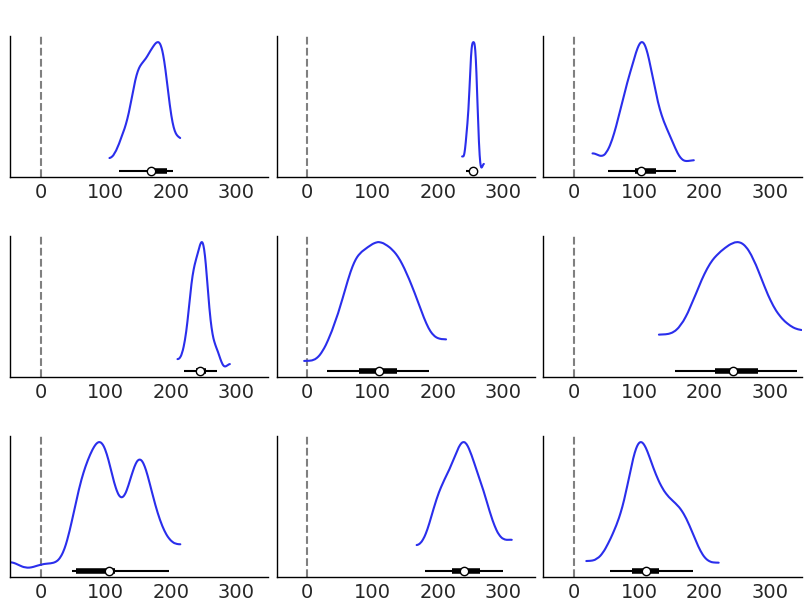

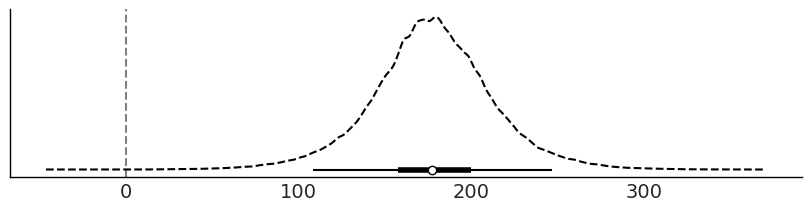

In [189]:
%matplotlib widget
pz.ppa(a_preliz_model)

In [190]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

NameError: name 'predictor_scaled' is not defined

In [191]:
data = df["height"]

In [192]:
mu_grid = np.linspace(150, 160, 200)
mu_prior = st.norm(178, 20).logpdf(mu_grid)

In [193]:
sigma_grid = np.linspace(7, 9, 200)
sigma_prior = st.norm(0, 50).logpdf(sigma_grid)

In [194]:
posterior = (
    # Likelihood
    st.norm(mu_grid.reshape(-1, 1, 1), sigma_grid.reshape(1, -1, 1))
    .logpdf(data)
    .sum(axis=2)
    # Priors
    + mu_prior
    + sigma_prior
)

In [195]:
posterior = np.exp(posterior - posterior.max())  # Numerical trick to avoid overfloat
posterior.shape

(200, 200)

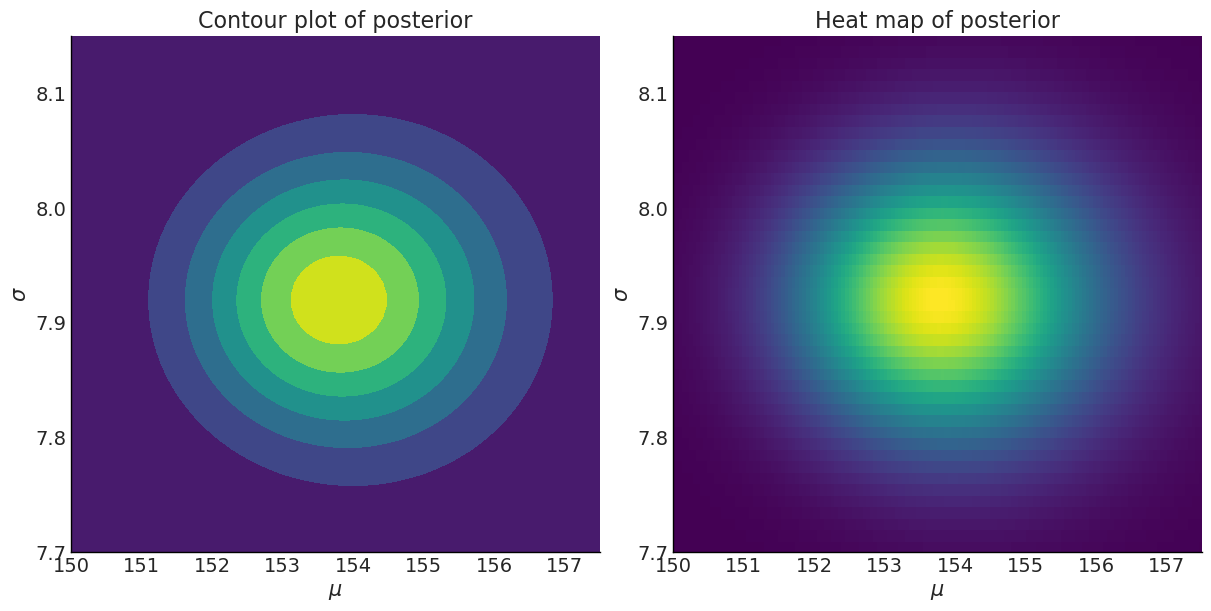

In [196]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
X, Y = np.meshgrid(mu_grid, sigma_grid)
plt.sca(axes[0])
plt.contourf(X, Y, posterior)
plt.xlim(left=150, right=157.5)
plt.ylim(bottom=7.7, top=8.15)
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma$")
plt.title("Contour plot of posterior")
plt.sca(axes[1])
plt.pcolormesh(X, Y, posterior)
plt.xlim(left=150, right=157.5)
plt.ylim(bottom=7.7, top=8.15)
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Heat map of posterior")
plt.show()

In [197]:
posterior /= posterior.sum()

In [198]:
idx = np.random.choice(np.prod(posterior.shape), p=posterior.flatten(), size=100000)
idx = np.vstack([idx // len(mu_grid), idx % len(mu_grid)])
samples = np.vstack((mu_grid[idx[0]], sigma_grid[idx[1]]))

In [199]:
# Flatten the 2D array
flattened_probabilities = posterior.flatten()
# Sample indices from the flattened array
sampled_indices_flat = np.random.choice(
    flattened_probabilities.size, p=flattened_probabilities, size=10000
)
# Reshape sampled indices back to 2D
sampled_indices_2d = np.unravel_index(sampled_indices_flat, posterior.shape)

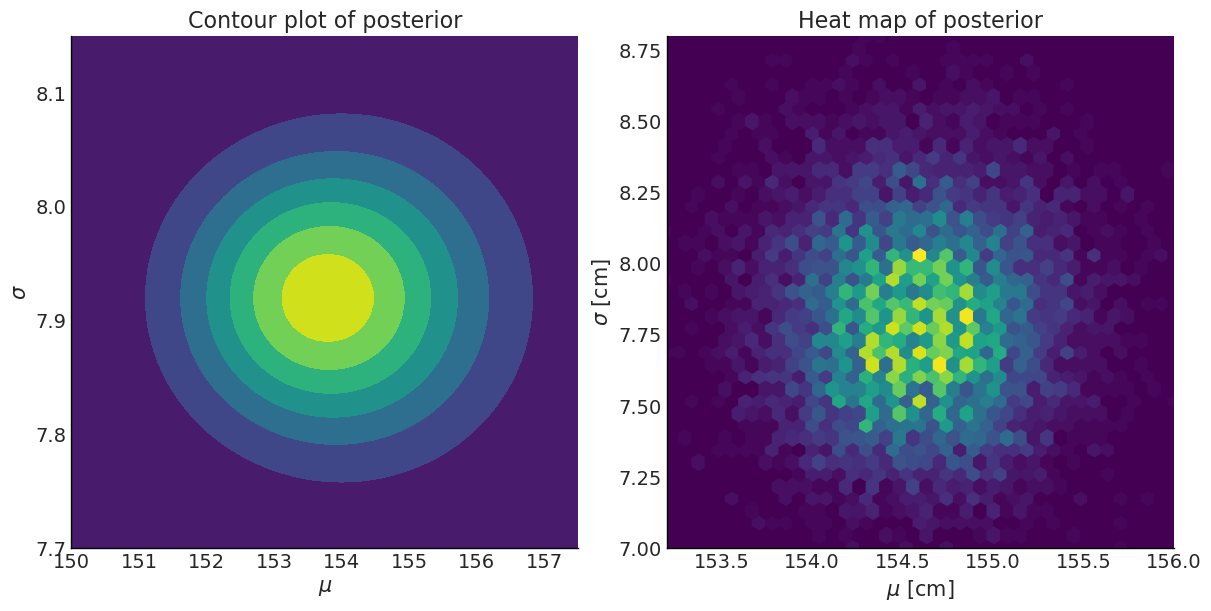

In [200]:
# plt.hexbin(*samples, gridsize=40)
plt.hexbin(
    x=mu_grid[sampled_indices_2d[0]], y=sigma_grid[sampled_indices_2d[1]], gridsize=40
)
# if you want to look at the scatter plot, though I don't think it's as useful:
# plt.scatter(*samples, s=0.5, alpha=0.1, color='red')
plt.xlim(left=153.2, right=156)
plt.ylim(bottom=7, top=8.8)
plt.xlabel("$\mu$ [cm]")
plt.ylabel("$\sigma$ [cm]")
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/learningbayesianstatistics/lib/python3.11/site-packages/seaborn/axisgrid.py:1766: UserWarning: The figure layout has changed to tight
  f.tight_layout()


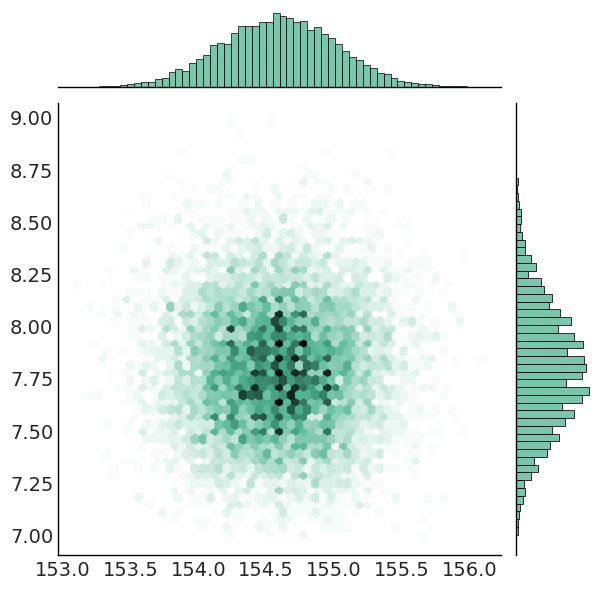

In [201]:
sns.jointplot(
    x=mu_grid[sampled_indices_2d[0]],
    y=sigma_grid[sampled_indices_2d[1]],
    kind="hex",
    color="#4CB391",
)

<Axes: title={'center': 'x'}>

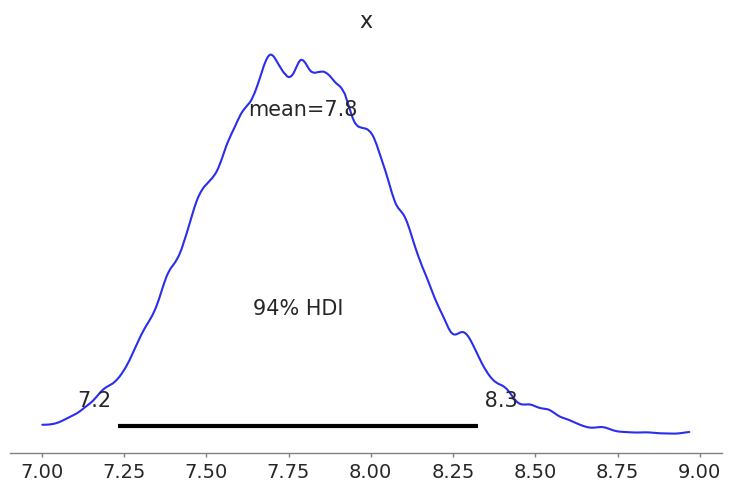

In [202]:
az.plot_posterior(sigma_grid[sampled_indices_2d[1]])

<Axes: title={'center': 'x'}>

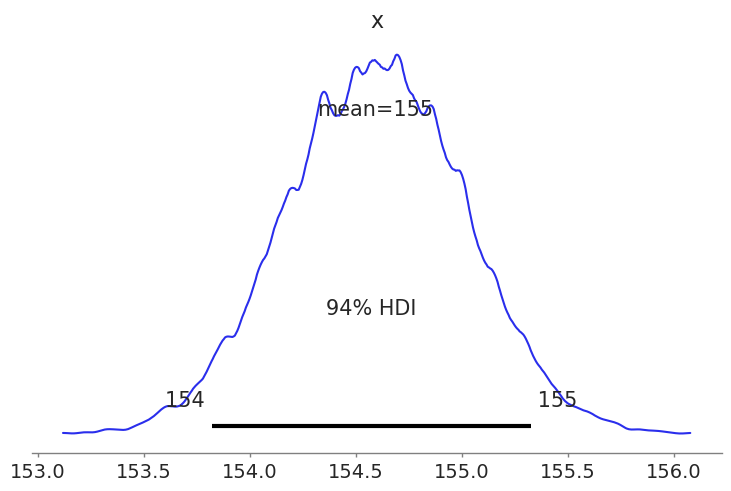

In [203]:
az.plot_posterior(mu_grid[sampled_indices_2d[0]])

posterior compatibility intervals:

R code 4.22

In [204]:
print(az.hdi(mu_grid[sampled_indices_2d[0]]))
print(az.hdi(sigma_grid[sampled_indices_2d[0]]))

[153.81909548 155.32663317]
[7.7638191  8.06532663]


R code 4.23

In [205]:
d3 = data.sample(n=20)

R code 4.24

/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_13759/3306144624.py:33: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


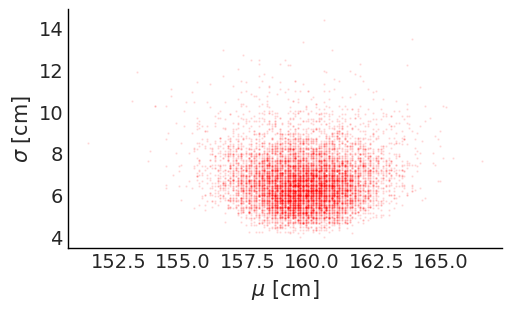

In [206]:
mu_list = np.linspace(150, 170, 200)
sigma_list = np.linspace(4, 20, 200)

post2 = (
    # Likelihood
    st.norm(mu_list.reshape(-1, 1, 1), sigma_list.reshape(1, -1, 1))
    .logpdf(d3)
    .sum(axis=2)
    # Priors
    + st.norm(178, 20).logpdf(mu_list)
    + st.norm(0, 50).logpdf(sigma_list)
)

# See note  in Statistical Rethinking 2nd ed for an explation of why to subtract post2.max()
post2 = np.exp(post2 - post2.max())
post2 /= post2.sum()

post2_flatten = post2.flatten()
indicies = np.random.choice(post2_flatten.size, p=post2_flatten, size=10000)
sample2_rows = np.unravel_index(indicies, post2.shape)

sample2_mu = mu_list[sample2_rows[0]]
sample2_sigma = sigma_list[sample2_rows[1]]

fix, ax = plt.subplots(figsize=(5, 3))
# plt.hexbin(x=sample2_mu, y=sample2_sigma, gridsize=40)
# if you want to look at the scatter plot, though I don't think it's as useful:
ax.scatter(x=sample2_mu, y=sample2_sigma, s=0.5, alpha=0.1, color="red")
# plt.xlim(left=150, right=170)
# plt.ylim(bottom=4, top=20)
ax.set(xlabel=r"$\mu$ [cm]", ylabel=r"$\sigma$ [cm]")

fig.tight_layout()
# plt.show()

R code 4.25

<Axes: title={'center': 'x'}>

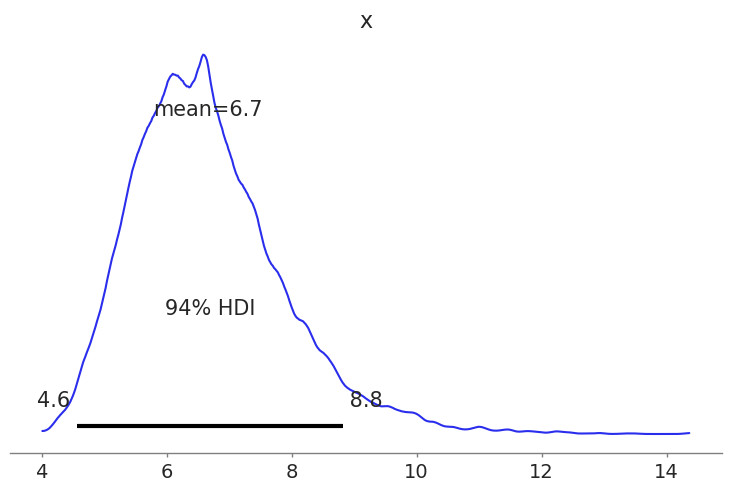

In [207]:
az.plot_posterior(sample2_sigma)

In [208]:
# start = np.array([data.mean(), ])
# start.shape

In [209]:
# Inspired by
# update to PYMC5 
# See
# added starting point argument

def quap(vars, start=None, n_samples=10_000):

    map = pm.find_MAP(vars=vars, start=start)

    m = pm.modelcontext(None)
    for var in vars:
        if m.rvs_to_transforms[var] is not None:
            m.rvs_to_transforms[var] = None
            # change name so that we can use `map[var]` value
            var_value = m.rvs_to_values[var]
            var_value.name = var.name

    H = pm.find_hessian(map, vars=vars)
    cov = np.linalg.inv(H)
    mean = np.concatenate([np.atleast_1d(map[v.name]) for v in vars])
    posterior = st.multivariate_normal(mean=mean, cov=cov)
    draws = posterior.rvs(n_samples)[np.newaxis, ...]
    if draws.ndim == 2:
        draws = draws[..., np.newaxis]
    samples = {}
    i = 0
    for v in vars:
        var_size = map[v.name].size
        samples[v.name] = draws[:, :, i : i + var_size]
        if var_size == 1:
            samples[v.name] = samples[v.name].squeeze(axis=-1)
        i += var_size
    return az.convert_to_inference_data(samples), posterior

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

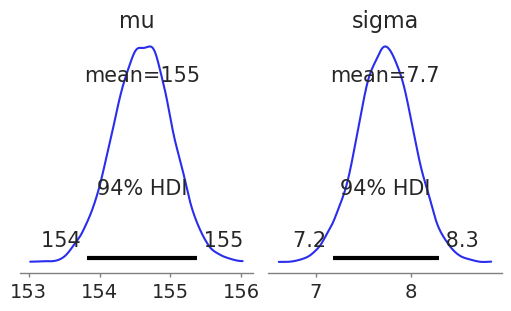

In [210]:
fig, ax = plt.subplots(ncols=2, figsize=(5, 3))

start = {"mu": data.mean(), "sigma": data.std()}

with pm.Model() as m:
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", 0, 50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data)
    idata, posterior = quap([mu, sigma], start=start)

az.plot_posterior(idata, ax=ax)

In [222]:
az.extract(idata, num_samples=20)

<xarray.Dataset>
Dimensions:  (sample: 20)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int64 9057 7603 7065 1565 8278 ... 9017 4619 4200 1504
Data variables:
    mu       (sample) float64 154.7 154.8 154.0 154.5 ... 155.0 154.3 154.5
    sigma    (sample) float64 7.781 7.633 7.474 7.687 ... 7.434 7.904 7.345
Attributes:
    created_at:     2024-05-10T08:24:57.372204
    arviz_version:  0.16.1

In [220]:
def precis(samples):
    return az.summary(samples,kind='stats', hdi_prob=0.89).round(2)

In [221]:
precis(idata)

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.61,0.41,153.94,155.25
sigma,7.73,0.29,7.26,8.20


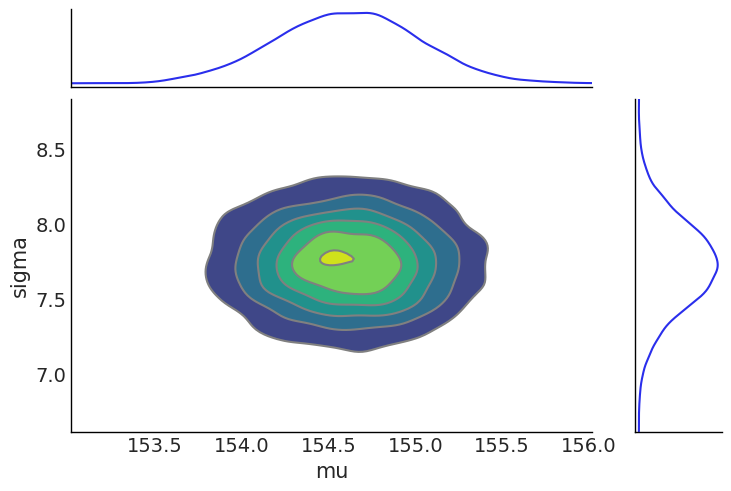

In [217]:
az.plot_pair(idata, kind='kde', marginals=True);

In [86]:
def vcov(posterior):
    return posterior.cov

In [90]:
cov = vcov(posterior)
cov

array([[0.16973961, 0.00021803],
       [0.00021803, 0.08490584]])

In [ ]:
def extract_samples(dist, size):
    samples = dist.rvs(size=size)
    return pd.DataFrame({"mu": samples[:, 0], "sigma": samples[:, 1]})

In [112]:
post = posterior.rvs(size=10000)
np.mean(post[:,0])

st.multivariate_normal multivariate_normal_frozen

154.60633098910483

In [113]:
dataset = 

In [116]:
precis(dataset)

,mu,sigma
count,10000.000000,10000.000000
mean,154.606331,7.735729
std,0.412230,0.287581
min,152.877503,6.592921
5.5%,153.944810,7.276629
50%,154.607721,7.738844
94.5%,155.259209,8.191173
max,156.525883,8.786938


In [103]:
def cov2cor(c: np.ndarray) -> np.ndarray:
    """
    Return a correlation matrix given a covariance matrix.
    : c = covariance matrix
    """
    D = np.zeros(c.shape)
    np.fill_diagonal(D, np.sqrt(np.diag(c)))
    invD = inv(D)
    return invD @ cov @ invD

(2, 2)

In [106]:
cov2cor(cov)

array([[1.        , 0.00181618],
       [0.00181618, 1.        ]])

In [117]:
N = 100
a = st.norm(loc=178, scale=20).rvs(N)
b = st.norm(loc=0, scale=10).rvs(N)

In [120]:
d2 = df

[Text(0.5, 0, 'weight'), Text(0, 0.5, 'height'), (-100.0, 400.0)]

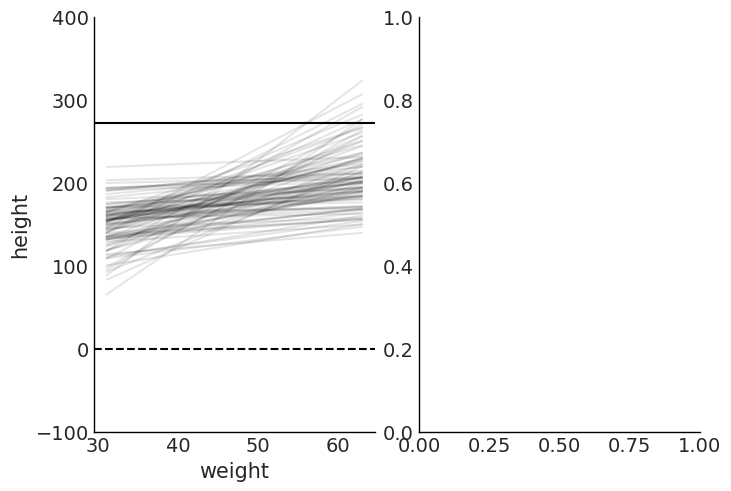

In [128]:
fig, ax = plt.subplots(ncols=2)

x = np.linspace(d2["weight"].min(), d2["weight"].max())
xbar = d2["weight"].mean()
for i in range(N):
    ax[0].plot(x, a[i] + b[i]*(x - xbar), color="black", alpha=0.1)
ax[0].axhline(272, color="black")
ax[0].axhline(0, color="black", linestyle="--")
ax[0].set(xlabel='weight', ylabel='height', ylim=(-100, 400))


In [130]:
# Sample from new prior
a = st.norm(loc=178, scale=20).rvs(N)
b = st.lognorm(scale=np.exp(0), s=1).rvs(N)

# Plot regression lines from the prior
x = np.linspace(d2["weight"].min(), d2["weight"].max())
xbar = d2["weight"].mean()
for i in range(N):
    ax[1].plot(x, a[i] + b[i]*(x - xbar), color="black", alpha=0.1)
ax[1].axhline(272, color="black")
ax[1].axhline(0, color="black", linestyle="--")
ax[1].set(xlabel='weight', ylabel='height', ylim=(-100, 400));

[Text(0.5, 48.334, 'weight'),
 Text(759.0909444444442, 0.5, 'height'),
 (-100.0, 400.0)]

In [131]:
weight = d2["weight"]

In [146]:
with pm.Model() as m:

    sigma = pm.Uniform("sigma", 0, 10)
    a = pm.Normal("a", 178 , 20 )
    b = pm.LogNormal("b", 0 , 1 )

    mu = pm.Deterministic("mu", a + b * (weight - xbar))
    # Define likelihood
    likelihood = pm.Normal("w", mu=mu, sigma=sigma, observed=df['height'])

    idata, posterior = quap([a,b,sigma])


    # xdata = pm.ConstantData("w", weight, dims="obs_id")
    # xmean = pm.ConstantData("xbar", xbar)

    # # define priors
    # a = pm.Normal("intercept", mu=0, sigma=1)
    # slope = pm.Normal("slope", mu=0, sigma=1)
    # sigma = pm.HalfCauchy("sigma", beta=10)

    # mu = pm.Deterministic("mu", intercept + slope * xdata, dims="obs_id")

    # # define likelihood
    # likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_out, dims="obs_id")

    # idata, posterior = quap([intercept, slope,sigma])    


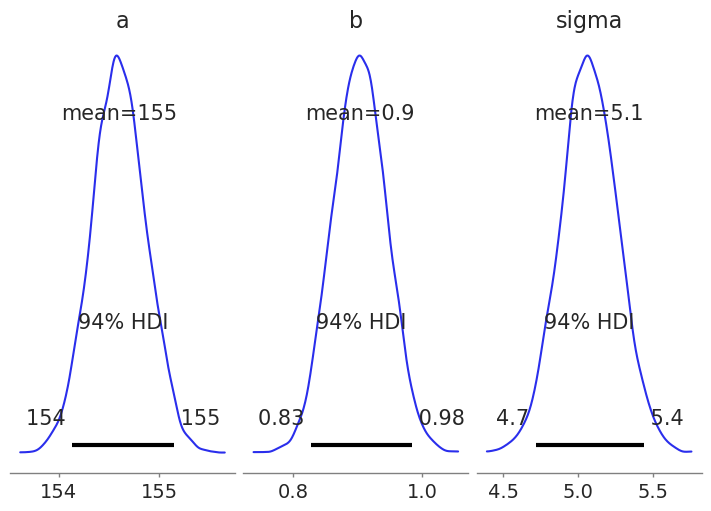

In [147]:
fig, ax = plt.subplots(ncols=3, figsize=(7,5))
az.plot_posterior(idata, ax=ax);

In [150]:
np.around(posterior.cov,3)

array([[ 0.073, -0.   ,  0.   ],
       [-0.   ,  0.002, -0.   ],
       [ 0.   , -0.   ,  0.037]])

In [152]:
az.hdi(idata)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    a        (hdi) float64 154.1 155.1
    b        (hdi) float64 0.8285 0.9832
    sigma    (hdi) float64 4.716 5.435

In [153]:
idata

Inference data with groups:
	> posterior

In [154]:
samples = posterior.rvs(size=10000)
samples = pd.DataFrame({"a": samples[:, 0], "b": samples[:, 1], "sigma": samples[:, 2]})

In [155]:
samples.head(4)

,a,b,sigma
0,154.319657,0.858665,5.059026
1,154.955278,0.920711,5.266152
2,154.430054,0.863951,5.276434
3,154.858558,1.006841,5.125257


[Text(0.5, 0, 'weight'),
 Text(0, 0.5, 'height'),
 Text(0.5, 1.0, 'Mean regression line of the posterior')]

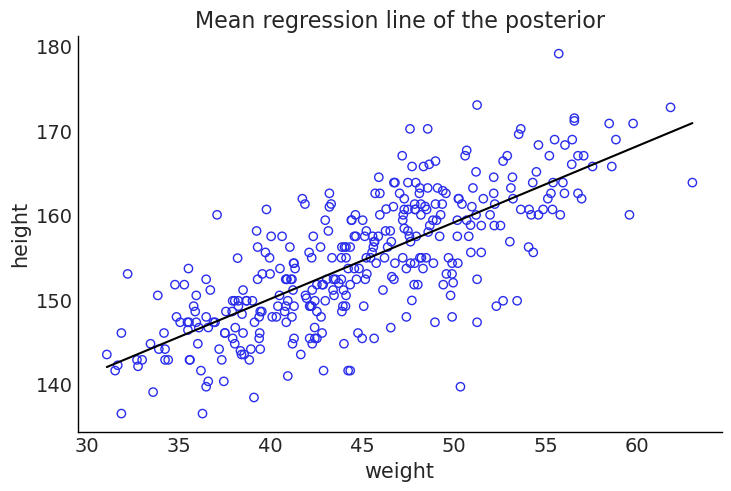

In [159]:
fig, ax = plt.subplots()
a = samples['a'].mean()
b = samples["b"].mean()
x = np.linspace(weight.min(), weight.max(), 10)
y = a + b * (x - xbar)
ax.scatter(weight, df['height'], label="data", facecolor="none", edgecolor="C0")
ax.plot(x, y, label="posterior mean", color="black")
ax.set(xlabel="weight", ylabel="height", title="Mean regression line of the posterior"  )


In [162]:
weight = df['weight'].to_numpy()
height = df['height'].to_numpy()

/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_13759/3805413467.py:36: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.3, wspace=0.15)


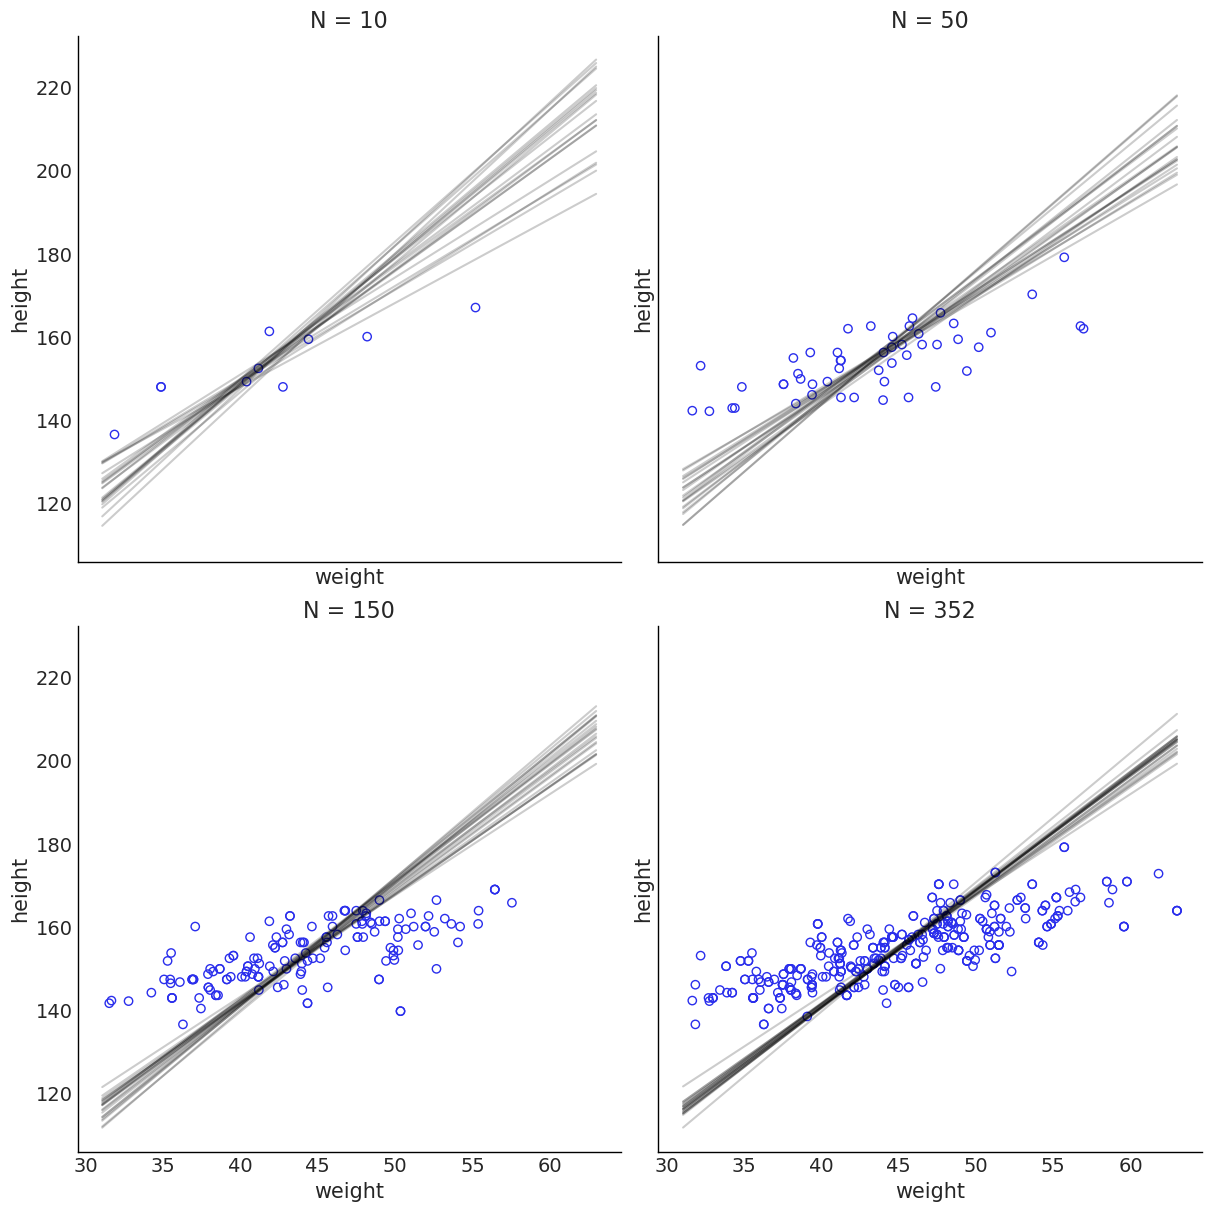

In [173]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharey=True, sharex=True)
for N, ax in zip((10, 50, 150, 352), axes.flatten()):
    # Subsample data
    idx = np.random.choice(len(weight), N)
    weight_, height_ = weight[idx], height[idx]
    # Recreate model/guide
    xbar = np.mean(weight_)

    with pm.Model() as m:
        sigma = pm.Uniform("sigma", 0, 10)
        a = pm.Normal("a", 178 , 20 )
        b = pm.LogNormal("b", 0 , 1 )
        mu = pm.Deterministic("mu", a + b * (weight_ - xbar))
        # Define likelihood
        likelihood = pm.Normal("w", mu=mu, sigma=sigma, observed=height_)
        idata, posterior = quap([a,b,sigma])

    samples = posterior.rvs(size=20)
    samples = pd.DataFrame({"a": samples[:, 0], "b": samples[:, 1], "sigma": samples[:, 2]})

    # Plot the data
    ax.scatter(weight_, height_, facecolor="none", edgecolor="C0")
    # Plot all sampled lines
    
    for i in range(20):
        a = samples["a"][i]
        b = np.exp(samples["b"][i])
        x = np.linspace(weight.min(), weight.max(), 10)
        y = a + b * (x - xbar)
        ax.plot(x, y, color="black", alpha=0.2)
    ax.set_xlabel("weight")
    ax.set_ylabel("height")
    # ax.set_ylim(140, 180)
    ax.set_title(f"N = {N}")

plt.subplots_adjust(hspace=0.3, wspace=0.15)
plt.show()